In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

In [3]:
import optuna
import scipy.stats as stats
from optuna.pruners import HyperbandPruner

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Importación de datos

In [8]:
# Definir la ruta común
base_path = "../Medical Appointment No Show/Proceced Datasets/"

# Función para importar DataFrames y eliminar el nombre del índice
def import_with_index(filepath):
    # Leer el CSV con el índice
    df = pd.read_csv(filepath, index_col=0)
    # Eliminar el nombre del índice
    df.index.name = None
    return df

# Importar los DataFrames de forma manual

X_train = import_with_index(os.path.join(base_path, 'X_train_pipe.csv'))
X_test = import_with_index(os.path.join(base_path, 'X_test_pipe.csv'))

X_train_trees = import_with_index(os.path.join(base_path, 'X_train_pipe_trees.csv'))
X_test_trees = import_with_index(os.path.join(base_path, 'X_test_pipe_trees.csv'))

y_train = import_with_index(os.path.join(base_path, 'y_train_pipe.csv'))
y_test = import_with_index(os.path.join(base_path, 'y_test_pipe.csv'))

In [9]:
X_train.shape

(88417, 35)

In [10]:
# Porcentaje de inasistencias
y_train.sum()/len(y_train)

No-show    0.200855
dtype: float64

In [11]:
# Total insasistencias
y_train.sum()

No-show    17759
dtype: int64

In [12]:
X_train.head(4)

,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,FirstTimeAppointment,Comorbilidades,InteraccionCondicionesHandcap,RiesgoGeneral,...,DayOfWeek_Tuesday,DayOfWeek_Wednesday,ScheduledPeriod_Noche,ScheduledPeriod_Tarde,Age_group_Adultos mayores (60-79),Age_group_Adultos medios (40-59),Age_group_Ancianos (80+),Age_group_Infancia (0-6),Age_group_Jóvenes adultos (20-39),Age_group_Niñez (7-12)
64200,0,0,0,0,0.0,0,1,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
91954,0,0,0,0,0.0,0,1,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
11678,0,0,0,0,0.0,0,1,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
84806,0,0,0,0,0.0,1,0,0.0,0.0,0.0,...,1,0,0,1,1,0,0,0,0,0


In [13]:
y_train.head(4)

,No-show
64200,0
91954,0
11678,0
84806,0


In [14]:
all(X_train.index == y_train.index)

True

In [15]:
X_test.head(4)

,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,FirstTimeAppointment,Comorbilidades,InteraccionCondicionesHandcap,RiesgoGeneral,...,DayOfWeek_Tuesday,DayOfWeek_Wednesday,ScheduledPeriod_Noche,ScheduledPeriod_Tarde,Age_group_Adultos mayores (60-79),Age_group_Adultos medios (40-59),Age_group_Ancianos (80+),Age_group_Infancia (0-6),Age_group_Jóvenes adultos (20-39),Age_group_Niñez (7-12)
104581,0,0,0,0,0.0,0,0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
106123,0,0,0,0,0.0,1,0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
54961,0,0,0,0,0.0,0,1,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
40500,0,0,0,0,0.0,1,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
y_test.head(4)

,No-show
104581,0
106123,0
54961,0
40500,0


In [17]:
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

In [18]:
# Asegúrate de que y_train sea un Series unidimensional
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]  # Seleccionar la primera columna como un Series

# Asegúrate de que y_train sea un Series unidimensional
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]  # Seleccionar la primera columna como un Series

#### Analizo la importancia de las caracteristicas con Mutual information

In [19]:
# to obtain the mutual information values
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile

Text(0, 0.5, 'Mutual Information')

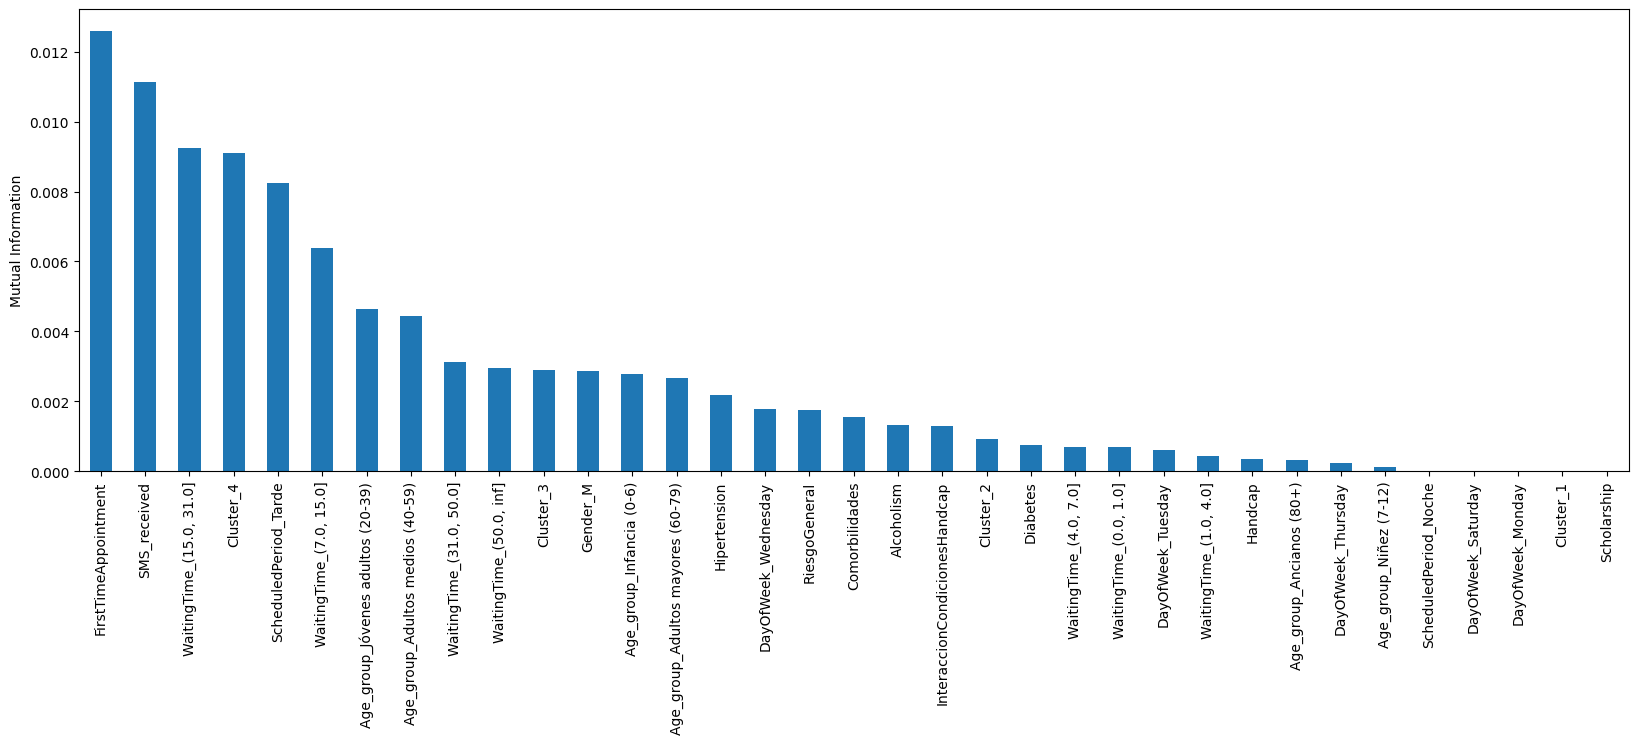

In [20]:
# the smaller the value of the mi, the less information we can infer from the feature about the target
mi = mutual_info_classif(
    X = X_train, 
    y = y_train,
    discrete_features = False, 
    n_neighbors=3,
    random_state=3,
)

# 1) let's capture the above array in a pandas series
# 2)add the variable names in the index
# 3) sort the features based on their mutual information value
# 4) and make a var plot

mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [21]:
list_to_drop = ['Scholarship', 'DayOfWeek_Monday', 'DayOfWeek_Tuesday', 'DayOfWeek_Thursday', 'DayOfWeek_Wednesday', 'Handcap', 'Alcoholism', 
                'InteraccionCondicionesHandcap', 'WaitingTime_(0.0, 1.0]', 'WaitingTime_(1.0, 4.0]', 'WaitingTime_(4.0, 7.0]', 
                'Cluster_1', 'Cluster_2', 'Age_group_Ancianos (80+)', 'Age_group_Niñez (7-12)', 'Age_group_Infancia (0-6)',
                'ScheduledPeriod_Noche', 'Comorbilidades', 'DayOfWeek_Saturday', 'Diabetes'
               ]
X_train = X_train.drop(columns = list_to_drop)
X_test = X_test.drop(columns = list_to_drop)

Text(0, 0.5, 'Mutual Information')

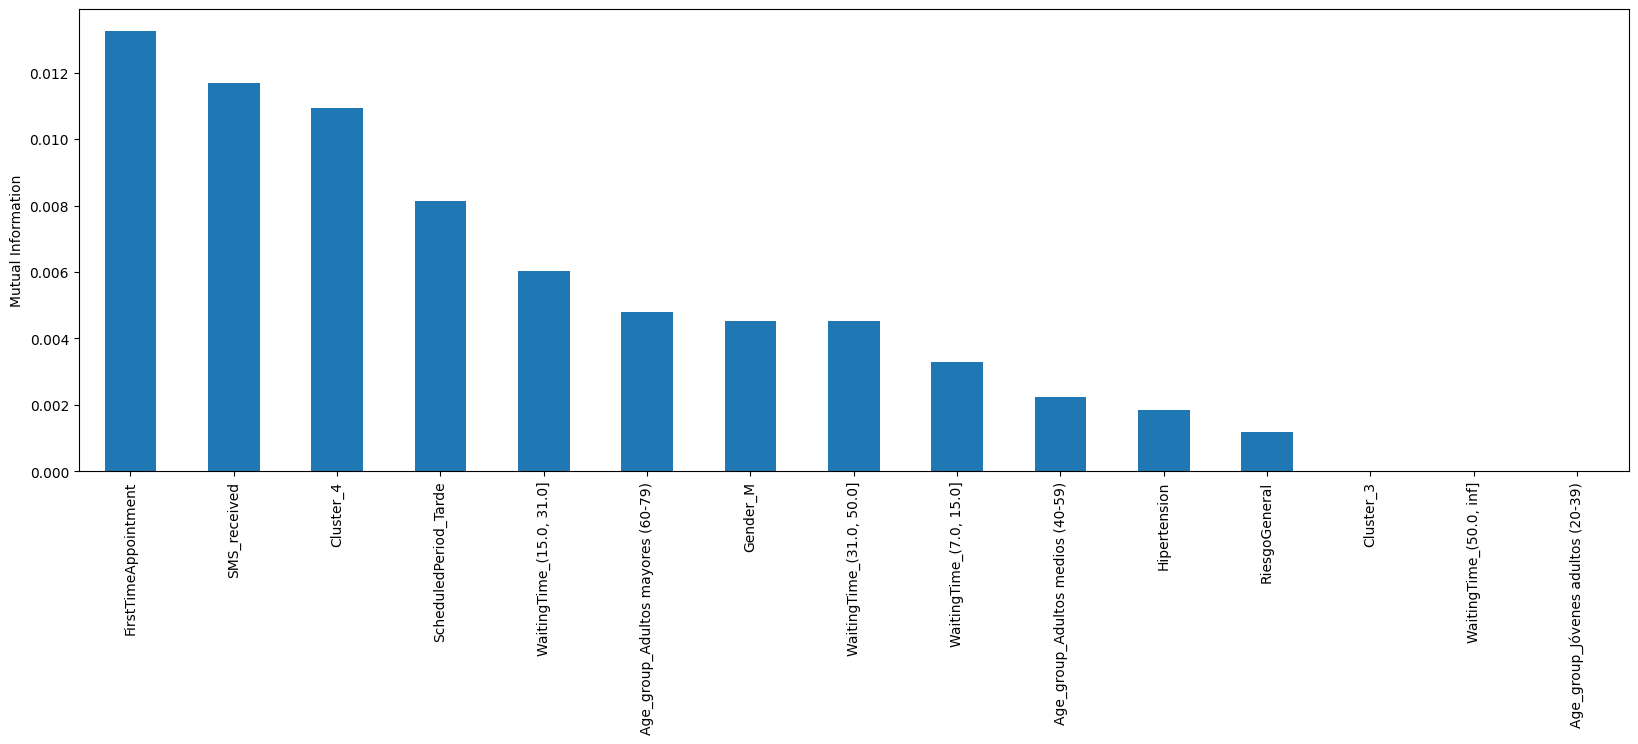

In [22]:
# the smaller the value of the mi, the less information we can infer from the feature about the target
mi = mutual_info_classif(
    X = X_train, 
    y = y_train,
    discrete_features = False, 
    n_neighbors=3,
    random_state=3,
)

mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

# Selección de modelo

#### Funciones para evaluar

In [23]:
def calculate_metric(y_true, y_pred, metric):
    if metric == 'accuracy':
        return accuracy_score(y_true, y_pred)
    elif metric == 'precision':
        return precision_score(y_true, y_pred)
    elif metric == 'recall':
        return recall_score(y_true, y_pred)
    elif metric == 'f1':
        return f1_score(y_true, y_pred)
    elif metric == 'roc_auc':
        return roc_auc_score(y_true, y_pred)  # Aquí asume que y_pred son probabilidades
    else:
        raise ValueError(f"Metric {metric} not supported")

In [24]:
def resultados(y, y_pred):
    """
    Esta función evalúa el rendimiento de un modelo de clasificación utilizando
    una matriz de confusión y un reporte de clasificación. 

    Parámetros:
    - y: array-like, valores verdaderos de las etiquetas de clase (etiquetas reales).
    - y_pred: array-like, valores predichos por el modelo (etiquetas predichas).
    """
    conf_matrix = confusion_matrix(y, y_pred, normalize='true')
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', vmin=0, vmax=1, center=0.5)
    plt.title("Matriz de Confusión")
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.show()
    print(classification_report(y, y_pred))

#### Funciones objetivos para determinar los mejores parametros con Optuna

In [25]:
def objective_logit(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'penalty': trial.suggest_categorical('logit_penalty', ['l1', 'l2']),
        'C': trial.suggest_float('logit_c', 1e-5, 1e2, log=True),
        'solver': trial.suggest_categorical('logit_solver', ['liblinear', 'saga']),
        'max_iter': trial.suggest_int('logit_max_iter', 100, 500)
    }
    
    # Crear el modelo utilizando **param
    model = LogisticRegression(**param)
    
    model.fit(X_train, y_train)

    if metric == 'roc_auc':
        preds = model.predict_proba(X_test)[:, 1]  # Obtener la probabilidad de la clase positiva
    else:
        preds = model.predict(X_test)
    
    # Llamar a la función para calcular la métrica
    return calculate_metric(y_test, preds, metric)

In [26]:
def objective_svc(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'C': trial.suggest_float('svc_c', 1e-5, 1e2, log=True),
        'kernel': trial.suggest_categorical('svc_kernel', ['linear', 'poly']),
        'gamma': trial.suggest_categorical('svc_gamma', ['scale', 'auto']),
        'degree': trial.suggest_int('svc_degree', 2, 4),
        'random_state': 42
    }
    
    # Crear el modelo base SVC
    model = SVC(**param)
    
    # Calibrar para obtener predict_proba
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid')
    calibrated_model.fit(X_train, y_train)

    # Predicciones y cálculo de métricas
    if metric == 'roc_auc':
        preds = calibrated_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
    else:
        preds = calibrated_model.predict(X_test)
    
    return calculate_metric(y_test, preds, metric)

In [27]:
from sklearn.calibration import CalibratedClassifierCV

def objective_svc(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'C': trial.suggest_float('svc_c', 1e-5, 1e2, log=True),
        'kernel': trial.suggest_categorical('svc_kernel', ['linear', 'poly']),
        'gamma': trial.suggest_categorical('svc_gamma', ['scale', 'auto']),
        'degree': trial.suggest_int('svc_degree', 2, 4),
        'random_state': 42
    }
    
    # Crear el modelo base SVC
    model = SVC(**param)
    
    # Calibrar para obtener predict_proba
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid')
    calibrated_model.fit(X_train, y_train)

    # Predicciones y cálculo de métricas
    if metric == 'roc_auc':
        preds = calibrated_model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
    else:
        preds = calibrated_model.predict(X_test)
    
    return calculate_metric(y_test, preds, metric)


In [28]:
def objective_gbm(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_estimators': trial.suggest_int("gbm_n_estimators", 50, 200),
        'learning_rate': trial.suggest_float("gbm_learning_rate", 0.01, 0.2),
        'max_depth': trial.suggest_int("gbm_max_depth", 1, 25),
        'min_samples_split': trial.suggest_int("gbm_min_samples_split", 2, 100),
        'min_samples_leaf': trial.suggest_int("gbm_min_samples_leaf", 1, 200),
        'max_features': trial.suggest_categorical("gbm_max_features", ['sqrt', 'log2', None]),
        'random_state': 42
    }

    # Crear el modelo utilizando **param
    model = GradientBoostingClassifier(**param)
    
    model.fit(X_train, y_train)

    if metric == 'roc_auc':
        preds = model.predict_proba(X_test)[:, 1]  # Obtener la probabilidad de la clase positiva
    else:
        preds = model.predict(X_test)
    
    # Llamar a la función para calcular la métrica
    return calculate_metric(y_test, preds, metric)

In [29]:
def objective_knn(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_neighbors': trial.suggest_int('knn_n_neighbors', 5, 50, step=2),
        'weights': trial.suggest_categorical('knn_weights', ['uniform', 'distance']),
        'p': trial.suggest_int('knn_p', 1, 2),
    }

    # Crear el modelo utilizando **param
    model = KNeighborsClassifier(**param)
    
    model.fit(X_train, y_train)

    if metric == 'roc_auc':
        preds = model.predict_proba(X_test)[:, 1]  # Obtener la probabilidad de la clase positiva
    else:
        preds = model.predict(X_test)
    
    # Llamar a la función para calcular la métrica
    return calculate_metric(y_test, preds, metric)

In [30]:
def objective_naive(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'var_smoothing': trial.suggest_float('naive_var_smoothing', 1e-3, 1e0, log=True)
    }

    # Crear el modelo utilizando **param
    model = GaussianNB(**param)
    
    model.fit(X_train, y_train)

    if metric == 'roc_auc':
        preds = model.predict_proba(X_test)[:, 1]  # Obtener la probabilidad de la clase positiva
    else:
        preds = model.predict(X_test)
    
    # Llamar a la función para calcular la métrica
    return calculate_metric(y_test, preds, metric)

In [31]:
def objective_rf(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_estimators': trial.suggest_int("rf_n_estimators", 50, 300),
        'max_depth': trial.suggest_int("rf_max_depth", 1, 30),
        'min_samples_split': trial.suggest_int("rf_min_samples_split", 2, 400),
        'min_samples_leaf': trial.suggest_int("rf_min_samples_leaf", 1, 400),
        'max_features': trial.suggest_categorical("rf_max_features", [None, 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical("rf_bootstrap", [True, False]),
        'random_state': 42
    }
    
    # Crear el modelo utilizando **param
    model = RandomForestClassifier(**param)
    model.fit(X_train, y_train)
    
    # Predicciones y cálculo de métricas
    if metric == 'roc_auc':
        preds = model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
    else:
        preds = model.predict(X_test)
    
    return calculate_metric(y_test, preds, metric)

In [32]:
def objective_dt(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'max_depth': trial.suggest_int("dt_max_depth", 1, 20),
        'min_samples_split': trial.suggest_int("dt_min_samples_split", 2, 400),
        'min_samples_leaf': trial.suggest_int("dt_min_samples_leaf", 1, 400),
        'criterion': trial.suggest_categorical("dt_criterion", ["gini", "entropy"]),
        'random_state': 42
    }

    # Crear el modelo utilizando **param
    model = DecisionTreeClassifier(**param)
    
    model.fit(X_train, y_train)

    if metric == 'roc_auc':
        preds = model.predict_proba(X_test)[:, 1]  # Obtener la probabilidad de la clase positiva
    else:
        preds = model.predict(X_test)
    
    # Llamar a la función para calcular la métrica
    return calculate_metric(y_test, preds, metric)

In [33]:
def objective_lgbm(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-5, 1e-2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'random_state': 42,
        'class_weight': 'balanced'  # Address class imbalance
    }

    # Crear el modelo utilizando **param
    model = lgb.LGBMClassifier(**param, verbose=0)
    
    model.fit(X_train, y_train)

    if metric == 'roc_auc':
        preds = model.predict_proba(X_test)[:, 1]  # Obtener la probabilidad de la clase positiva
    else:
        preds = model.predict(X_test)
    
    # Llamar a la función para calcular la métrica
    return calculate_metric(y_test, preds, metric)

In [34]:
# model = model_dict['gbm'](param) --> No entendí bien porque me recomendo esto ChatGPT

In [35]:
# Adapto los nombres de las columnas para que lgb.LGBMClassifier puede manejarlas
X_train.columns = X_train.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^A-Za-z0-9_]+', '_', regex=True)

#### Busco los mejores parametros para diferentes modelos

In [36]:
# Interesa optimizar tanto el recall como la presición
chosen_metric = 'roc_auc'

In [37]:
# Diccionario con los modelos y sus funciones objective correspondientes
model_dict = {
    'lgbm': objective_lgbm,
    'knn': objective_knn,
    'naive': objective_naive,
    'dt': objective_dt,
    'logit': objective_logit,
    'rf': objective_rf,
    # 'svc': objective_svc, con auc_roc requiere mucho costo computacional
    'gbm': objective_gbm
}

In [38]:
# Intentar leer el archivo CSV, si no existe, ejecutar la optimización
try:
    # Intentar leer el archivo CSV
    trials_df1 = pd.read_csv("../Medical Appointment No Show/parameters_trials.csv")
    print("Archivo leído correctamente.\n")

except FileNotFoundError:
    # Si el archivo no existe, ejecutar la optimización
    print("Archivo no encontrado. Ejecutando optimización...")

    best_params_df = pd.DataFrame(columns=["model", "params", "score"])  # Agregar columna para la métrica

    # Loop sobre los modelos
    for model_name, objective_func in model_dict.items():
        # Crear el estudio para cada modelo
        study = optuna.create_study(direction='maximize', pruner=HyperbandPruner())

        # Optimizar el modelo con Optuna utilizando su función objective correspondiente
        study.optimize(lambda trial: objective_func(trial, X_train, y_train, metric = chosen_metric), n_trials = 40)

        # Obtener los mejores parámetros y la mejor puntuación
        best_params = study.best_params
        best_score = study.best_value  # Obtiene la mejor puntuación (por ejemplo, accuracy o roc_auc)

        # Imprimir mensaje indicando que la búsqueda terminó para el modelo actual
        print(f'Búsqueda en {model_name} finalizada')
        
        # Guardar en el DataFrame usando pd.concat()
        best_params_df = pd.concat([best_params_df, pd.DataFrame([{"model": model_name, 
                                                                   "params": best_params, 
                                                                   "score": best_score}])], ignore_index=True)

    # Guardar los resultados en un archivo CSV
    best_params_df.to_csv("../Medical Appointment No Show/parameters_trials.csv", index=False)
    print("Resultados guardados en parameters_trials.csv")

# Leer el archivo CSV después de guardar
trials_df1 = pd.read_csv("../Medical Appointment No Show/parameters_trials.csv")
print("Archivo leído correctamente después de la optimización.\n")

Archivo leído correctamente.

Archivo leído correctamente después de la optimización.



In [39]:
trials_df1

,model,params,score
0,lgbm,"{'num_leaves': 48, 'max_depth': 3, 'learning_r...",0.681546
1,knn,"{'knn_n_neighbors': 47, 'knn_weights': 'unifor...",0.657534
2,naive,{'naive_var_smoothing': 0.36842649871821564},0.657052
3,dt,"{'dt_max_depth': 12, 'dt_min_samples_split': 2...",0.679168
4,logit,"{'logit_penalty': 'l2', 'logit_c': 0.003145507...",0.665791
5,rf,"{'rf_n_estimators': 300, 'rf_max_depth': 12, '...",0.681642
6,gbm,"{'gbm_n_estimators': 78, 'gbm_learning_rate': ...",0.681743


In [40]:
trials_df1.loc[4, 'params']

"{'logit_penalty': 'l2', 'logit_c': 0.0031455075403841386, 'logit_solver': 'liblinear', 'logit_max_iter': 309}"

In [41]:
def remove_prefix_and_modify_params(params, model_name, prefix):
    """Elimina el prefijo de los parámetros y cambia 'c' a 'C' para logit y svc."""
    
    # Eliminar el prefijo de los parámetros
    new_params = {}
    for key, value in params.items():

        # Eliminar el prefijo y mantener el valor del parámetro
        if key.startswith(prefix):
            new_key = key[len(prefix):]  # Eliminar el prefijo
        else:
            new_key = key  # Si no tiene prefijo, usamos la clave original

        # Cambiar 'c' a 'C' para los modelos logit y svc
        if model_name in ['logit', 'svc'] and new_key == 'c':
            print(f"Se encontró 'c' como clave para {model_name}. Cambiando a 'C'.")
            new_key = 'C'  # Cambiar 'c' a 'C'

        new_params[new_key] = value
    
    return new_params

# Recorremos cada fila del DataFrame y removemos el prefijo de los parámetros
for index, row in trials_df1.iterrows():
    # Cargar los parámetros de la columna 'params' como diccionario
    params = eval(row['params'])  # Convertir string a diccionario

    # Obtener el nombre del modelo
    model_name = row['model']
    
    # Si el modelo es 'lgbm', no hay prefijo; en otros casos, usamos el nombre del modelo seguido de un guion bajo
    if model_name == "lgbm":
        prefix = ""
    else:
        prefix = f"{model_name}_"

    # Remover el prefijo y cambiar 'c' a 'C' si es necesario
    new_params = remove_prefix_and_modify_params(params, model_name, prefix)

    # Actualizar la columna 'params' con los nuevos parámetros sin prefijo
    trials_df1.at[index, 'params'] = new_params

# Imprimir el DataFrame actualizado después de la depuración
print("\nDataFrame actualizado:")
print(trials_df1)

Se encontró 'c' como clave para logit. Cambiando a 'C'.

DataFrame actualizado:
   model                                             params     score
0   lgbm  {'num_leaves': 48, 'max_depth': 3, 'learning_r...  0.681546
1    knn  {'n_neighbors': 47, 'weights': 'uniform', 'p': 1}  0.657534
2  naive             {'var_smoothing': 0.36842649871821564}  0.657052
3     dt  {'max_depth': 12, 'min_samples_split': 23, 'mi...  0.679168
4  logit  {'penalty': 'l2', 'C': 0.0031455075403841386, ...  0.665791
5     rf  {'n_estimators': 300, 'max_depth': 12, 'min_sa...  0.681642
6    gbm  {'n_estimators': 78, 'learning_rate': 0.033684...  0.681743


#### Evaluación más profunda

In [42]:
def model_evaluation(model, X_train, y_train, metric='accuracy'):
    """
    Esta función evalúa el rendimiento del modelo utilizando K-Fold Cross-Validation
    y devuelve métricas de rendimiento, así como el riesgo de sobreajuste.

    Parámetros:
    - model: el modelo a evaluar.
    - X_train: conjunto de datos de entrenamiento.
    - y_train: etiquetas del conjunto de entrenamiento.

    Retorna:
    - df: DataFrame con las métricas de rendimiento.
    - overfitting_risk: diccionario con información sobre el riesgo de sobreajuste.
    """
    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    try:
        # Estimación del error de generalización
        clf = cross_validate(
            model,
            X_train,
            y_train,
            scoring= metric,
            return_train_score=True,
            cv=kf
        )

        # Calcular valores para el conjunto de entrenamiento
        mean_train_score = np.mean(clf['train_score'])
        std_train_score = np.std(clf['train_score'])

        # Calcular el intervalo para el conjunto de entrenamiento
        interval_lower_train = mean_train_score - 3 * std_train_score
        interval_upper_train = mean_train_score + 3 * std_train_score

        # Calcular el puntaje medio y el intervalo para el conjunto de prueba
        mean_test_score = np.mean(clf['test_score']) if 'test_score' in clf else np.nan
        std_test_score = np.std(clf['test_score']) if 'test_score' in clf else np.nan

        # Calcular el intervalo para el conjunto de prueba
        interval_lower_test = mean_test_score - 3 * std_test_score if not np.isnan(mean_test_score) else np.nan
        interval_upper_test = mean_test_score + 3 * std_test_score if not np.isnan(mean_test_score) else np.nan

        # Crear el DataFrame con las métricas
        df = pd.DataFrame({
            'mean': [mean_train_score, mean_test_score],
            'std': [std_train_score, std_test_score],
            'interval_lower': [interval_lower_train, interval_lower_test],
            'interval_upper': [interval_upper_train, interval_upper_test]
        }, index=['train_set', 'test_set'])

        # Prueba t para comparar las puntuaciones de entrenamiento y prueba
        t_stat, p_value = stats.ttest_ind(clf['train_score'], clf['test_score'], equal_var=False)

        # Diccionario con la probabilidad de sobreajuste
        overfitting_risk = {
            't_statistic': t_stat,
            'p_value': p_value,
            'overfitting_likelihood': 'High' if p_value < 0.10 else 'Low'
        }

        return df, overfitting_risk

    except Exception as e:
        print(f"Error al evaluar el modelo: {e}")
        return None, None

In [43]:
model_dict = {
    'gbm': GradientBoostingClassifier,
    'knn': KNeighborsClassifier,
    'naive': GaussianNB,
    'dt': DecisionTreeClassifier,
    'lgbm': lgb.LGBMClassifier,
    'logit': LogisticRegression,
    'rf': RandomForestClassifier,
    'svc': SVC
}

In [44]:
# Nombre del archivo CSV relacionado con "comportamiento_mejores_parametros"
csv_filename = "best_params_results.csv"

# Verifica si el archivo ya existe
if os.path.exists(csv_filename):
    # Si el archivo existe, solo se lee y se omite el proceso de evaluación y guardado
    results_df = pd.read_csv(csv_filename)
    print("El archivo ya existe. Se han cargado los resultados desde el archivo.")
else:
    # Si el archivo no existe, se realiza el cálculo y se guarda el archivo
    results_df = pd.DataFrame(columns=["model", "mean_train_score", "std_train_score", "interval_lower_train", 
                                       "interval_upper_train", "mean_test_score", "std_test_score", 
                                       "interval_lower_test", "interval_upper_test", "overfitting_risk", "p_value"])

    # Para cada modelo en trials_df1, crea y entrena el modelo utilizando los parámetros
    for index, row in trials_df1.iterrows():
        model_name = row['model']
        params = row['params']

        # Si el modelo es 'lgbm', no necesita prefijo como los otros modelos
        if model_name != 'lgbm':
            # Remover el prefijo (modelo_name + "_") de los parámetros
            params = {k.replace(f'{model_name}_', ''): v for k, v in params.items()}

        # Crear el modelo usando los parámetros
        model_class = model_dict[model_name]
        model = model_class(**params)

        # Dividir el dataset en entrenamiento y validación
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        # Evaluar el modelo usando la función 'model_evaluation'
        df, overfitting_risk = model_evaluation(model, X_train, y_train, metric = chosen_metric)

        # Extraer los resultados de la evaluación
        mean_train_score = df.loc['train_set', 'mean']
        std_train_score = df.loc['train_set', 'std']
        interval_lower_train = df.loc['train_set', 'interval_lower']
        interval_upper_train = df.loc['train_set', 'interval_upper']
        
        mean_test_score = df.loc['test_set', 'mean']
        std_test_score = df.loc['test_set', 'std']
        interval_lower_test = df.loc['test_set', 'interval_lower']
        interval_upper_test = df.loc['test_set', 'interval_upper']

        # Extraer el valor p
        p_value = overfitting_risk.get('p_value', 1.0)

        # Crear un diccionario con los resultados para agregar al DataFrame
        results = {
            "model": model_name,
            "mean_train_score": mean_train_score,
            "std_train_score": std_train_score,
            "interval_lower_train": interval_lower_train,
            "interval_upper_train": interval_upper_train,
            "mean_test_score": mean_test_score,
            "std_test_score": std_test_score,
            "interval_lower_test": interval_lower_test,
            "interval_upper_test": interval_upper_test,
            "overfitting_risk": overfitting_risk['overfitting_likelihood'],
            "p_value": p_value
        }

        # Agregar los resultados al DataFrame de resultados
        results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
    
    # Guardar los resultados en el archivo CSV
    results_df.to_csv(csv_filename, index=False)
    print("El archivo ha sido creado y los resultados han sido guardados.")

El archivo ya existe. Se han cargado los resultados desde el archivo.


In [45]:
results_df

,model,mean_train_score,std_train_score,interval_lower_train,interval_upper_train,mean_test_score,std_test_score,interval_lower_test,interval_upper_test,overfitting_risk,p_value
0,lgbm,0.688806,0.001008,0.685781,0.691830,0.681904,0.003450,0.671554,0.692254,High,0.013749
1,knn,0.688705,0.002661,0.680722,0.696688,0.661892,0.008101,0.637590,0.686194,High,0.001664
2,naive,0.657777,0.001395,0.653591,0.661963,0.657453,0.004294,0.644571,0.670335,Low,0.891729
3,dt,0.688899,0.002077,0.682667,0.695130,0.671308,0.006399,0.652112,0.690505,High,0.003735
4,logit,0.641688,0.001326,0.637709,0.645667,0.640170,0.005348,0.624127,0.656214,Low,0.608068
5,rf,0.683655,0.003202,0.674050,0.693259,0.673496,0.012684,0.635444,0.711547,Low,0.187372
6,gbm,0.692714,0.000783,0.690364,0.695064,0.674541,0.003016,0.665494,0.683588,High,0.000148


In [46]:
results_df.columns

Index(['model', 'mean_train_score', 'std_train_score', 'interval_lower_train',
       'interval_upper_train', 'mean_test_score', 'std_test_score',
       'interval_lower_test', 'interval_upper_test', 'overfitting_risk',
       'p_value'],
      dtype='object')

In [47]:
from matplotlib.colors import Normalize, LinearSegmentedColormap

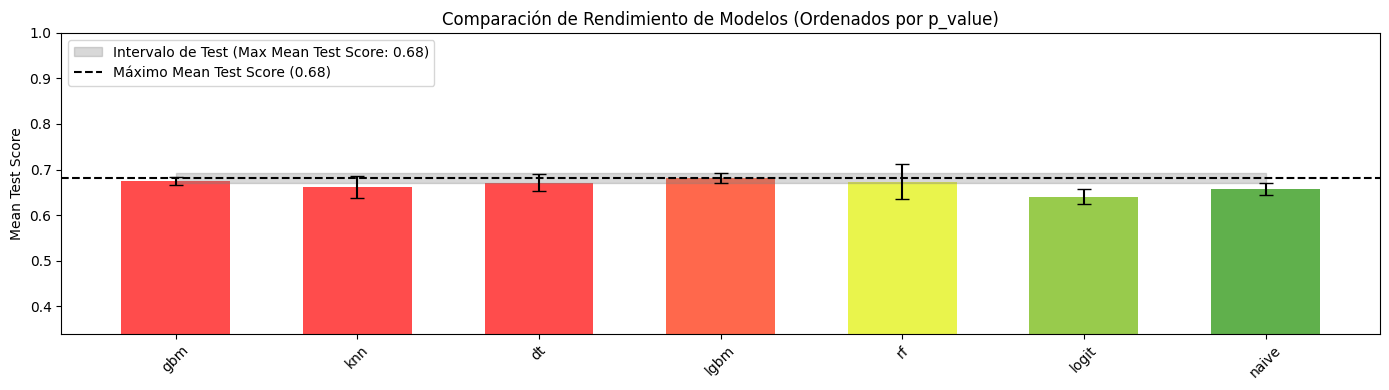

In [48]:
# Ordenar el DataFrame por el valor p creciente
results_df_sorted = results_df.sort_values(by='p_value')

# Crear el gráfico de barras
plt.figure(figsize=(14, 4))  # Ajustar el tamaño de la figura
bar_width = 0.6  # Hacer las barras el doble de anchas

# Obtener todos los modelos únicos después de ordenar
all_models = results_df_sorted['model'].unique()  # Obtener los modelos únicos

# Inicializar posición base
x_pos = np.arange(len(all_models))

# Crear un colormap personalizado para los valores p (ajustado a tus indicaciones)
colors = LinearSegmentedColormap.from_list(
    "p_value_gradient", [(0, 'red'), (0.075, 'yellow'), (1, 'green')])

# Normalizar los valores p de acuerdo con el rango entre 0 y 1
norm = Normalize(vmin=0, vmax=1)

# Graficar las métricas de test (mean_test_score y std_test_score)
max_mean_test_score = -np.inf  # Para encontrar el mayor mean_test_score
interval_lower_test_max = None  # Para almacenar el valor del intervalo inferior
interval_upper_test_max = None  # Para almacenar el valor del intervalo superior
min_mean_test_score = np.inf  # Para encontrar el menor mean_test_score

for i, model in enumerate(all_models):
    # Filtrar los datos para cada modelo
    filtered_df = results_df_sorted[results_df_sorted['model'] == model]
    
    # Obtener las métricas del modelo
    mean_test_score = filtered_df['mean_test_score'].values[0]
    test_std = filtered_df['std_test_score'].values[0] * 3  # Multiplicar la desviación estándar por 3
    p_value = filtered_df['p_value'].values[0]
    
    # Obtener los límites del intervalo de test
    interval_lower_test = filtered_df['interval_lower_test'].values[0]
    interval_upper_test = filtered_df['interval_upper_test'].values[0]
    
    # Actualizar el máximo y el mínimo mean_test_score, así como los límites del intervalo
    if mean_test_score > max_mean_test_score:
        max_mean_test_score = mean_test_score
        interval_lower_test_max = interval_lower_test
        interval_upper_test_max = interval_upper_test
    if mean_test_score < min_mean_test_score:
        min_mean_test_score = mean_test_score

    # Asignar el color basado en el valor p usando el colormap
    color = colors(norm(p_value))  # Aplicar normalización y obtener el color

    # Posicionar las barras
    plt.bar(x_pos[i], mean_test_score, yerr=test_std, capsize=5, 
            color=color, width=bar_width, alpha=0.7)

# Añadir una banda translucida entre interval_lower_test_max y interval_upper_test_max
plt.fill_between(
    [0, len(all_models) - 1],  # Todo el ancho del gráfico
    interval_lower_test_max, interval_upper_test_max,
    color='gray', alpha=0.3, label=f'Intervalo de Test (Max Mean Test Score: {max_mean_test_score:.2f})'
)

# Añadir línea horizontal en el valor máximo de mean_test_score
plt.axhline(y=max_mean_test_score, color='black', linestyle='--', label=f'Máximo Mean Test Score ({max_mean_test_score:.2f})')

# Añadir etiquetas y título
plt.title('Comparación de Rendimiento de Modelos (Ordenados por p_value)')
plt.xticks(x_pos, all_models, rotation=45)
plt.ylabel('Mean Test Score')

# Ajustar el límite del eje y
plt.ylim(min_mean_test_score - 0.3, 1.0)  # Se ajusta el límite inferior para incluir el valor mínimo

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [49]:
lgbm_best_params = trials_df1[trials_df1['model'] == 'logit']['params'].iloc[0]
print(lgbm_best_params)

{'penalty': 'l2', 'C': 0.0031455075403841386, 'solver': 'liblinear', 'max_iter': 309}


In [50]:
logit_classifier = LogisticRegression(**lgbm_best_params)
logit_classifier.fit(X_train, y_train)

LogisticRegression(C=0.0031455075403841386, max_iter=309, solver='liblinear')

In [51]:
y_pred = logit_classifier.predict(X = X_train)
y_pred_test = logit_classifier.predict(X_test)
y_pred_proba = logit_classifier.predict_proba(X_test)[:, 1]

Accuracy: 0.7939287006876583
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.5


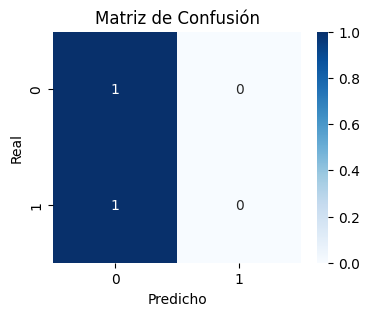

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     70658
           1       0.00      0.00      0.00     17759

    accuracy                           0.80     88417
   macro avg       0.40      0.50      0.44     88417
weighted avg       0.64      0.80      0.71     88417



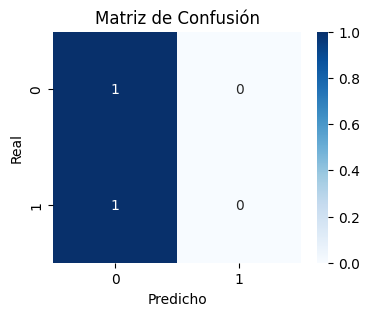

              precision    recall  f1-score   support

           0       0.79      1.00      0.89     17549
           1       0.00      0.00      0.00      4555

    accuracy                           0.79     22104
   macro avg       0.40      0.50      0.44     22104
weighted avg       0.63      0.79      0.70     22104



In [52]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
resultados(y_train, y_pred)
resultados(y_test, y_pred_test)

In [53]:
lgbm_best_params = trials_df1[trials_df1['model'] == 'lgbm']['params']
lgbm_best_params

0    {'num_leaves': 48, 'max_depth': 3, 'learning_r...
Name: params, dtype: object

In [54]:
# Initialize the LightGBM model
lgbm_classifier = lgb.LGBMClassifier(random_state=42)

In [55]:
lgbm_classifier.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 17759, number of negative: 70658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 88417, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200855 -> initscore=-1.380959
[LightGBM] [Info] Start training from score -1.380959


LGBMClassifier(random_state=42)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [56]:
y_pred = lgbm_classifier.predict(X = X_train)
y_pred_test = lgbm_classifier.predict(X_test)
y_pred_proba = lgbm_classifier.predict_proba(X_test)[:, 1]

In [57]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)

In [58]:
# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.7931596091205212
Precision: 0.3835616438356164
Recall: 0.006147091108671789
F1 Score: 0.012100259291270527
ROC AUC Score: 0.5017914212167668


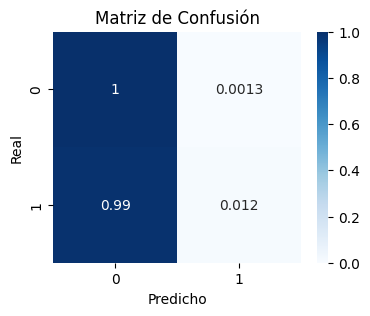

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     70658
           1       0.69      0.01      0.02     17759

    accuracy                           0.80     88417
   macro avg       0.74      0.51      0.46     88417
weighted avg       0.78      0.80      0.71     88417



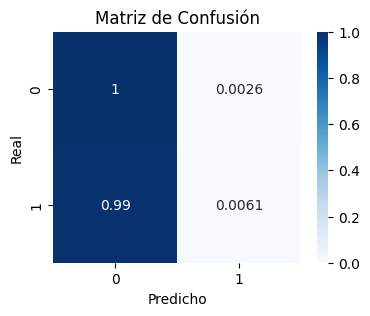

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     17549
           1       0.38      0.01      0.01      4555

    accuracy                           0.79     22104
   macro avg       0.59      0.50      0.45     22104
weighted avg       0.71      0.79      0.70     22104



In [59]:
resultados(y_train, y_pred)
resultados(y_test, y_pred_test)

### Como los datos estan desbalanceados, es decir, como solo aproximadamente el 20% de los pacientes se ausentó para la mayoria de los modelos las metricas se optimizan si predecimos que todos los pacientes se presentarán

#### Posibles soluciones

#### 1- Se optimiza los parametros de un modelo lgb.LGBMClassifier y se declara a el parametro class_weight como balanceado

In [60]:
study = optuna.create_study(direction='maximize')

[I 2024-11-08 14:25:06,117] A new study created in memory with name: no-name-37126f45-d697-4f7b-a95d-cdfd7c7790ad


In [61]:
# study.optimize(objective, n_trials=100)  # You can adjust n_trials to your needs
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)
# params = study.best_trial.params

In [62]:
params = {
    'num_leaves': 100, 
    'max_depth': 4, 
    'learning_rate': 0.13215250647759666, 
    'n_estimators': 232, 
    'min_child_samples': 385, 
    'min_child_weight': 1.0583625626497392e-05, 
    'subsample': 0.6056512017286949, 
    'colsample_bytree': 0.624791993158622, 
    'reg_alpha': 0.2130606637941088, 
    'reg_lambda': 0.9896972169484849
    }

In [63]:
params["random_state"] = 42
params["class_weight"] = "balanced"

In [64]:
lgbm_classifier = lgb.LGBMClassifier(**params)

In [65]:
lgbm_classifier.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 17759, number of negative: 70658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 88417, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMClassifier(class_weight='balanced', colsample_bytree=0.624791993158622,
               learning_rate=0.13215250647759666, max_depth=4,
               min_child_samples=385, min_child_weight=1.0583625626497392e-05,
               n_estimators=232, num_leaves=100, random_state=42,
               reg_alpha=0.2130606637941088, reg_lambda=0.9896972169484849,
               subsample=0.6056512017286949)

In [66]:
y_pred = lgbm_classifier.predict(X = X_train)
y_pred_test = lgbm_classifier.predict(X_test)
y_pred_proba = lgbm_classifier.predict_proba(X_test)[:, 1]

In [67]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)

In [68]:
# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.6431415128483532
Precision: 0.31981835874148556
Recall: 0.6493962678375411
F1 Score: 0.42857142857142855
ROC AUC Score: 0.6454571515266114


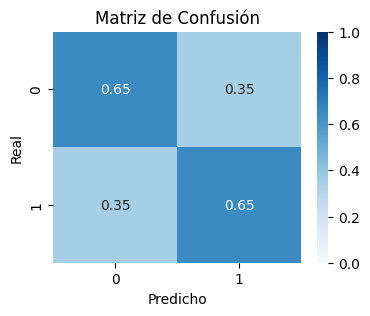

              precision    recall  f1-score   support

           0       0.88      0.65      0.75     70658
           1       0.32      0.65      0.43     17759

    accuracy                           0.65     88417
   macro avg       0.60      0.65      0.59     88417
weighted avg       0.77      0.65      0.68     88417



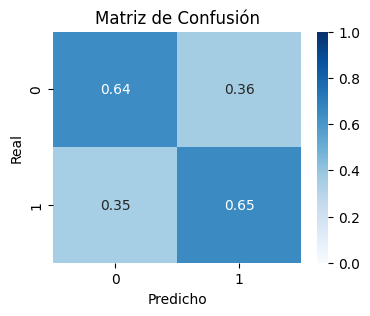

              precision    recall  f1-score   support

           0       0.88      0.64      0.74     17549
           1       0.32      0.65      0.43      4555

    accuracy                           0.64     22104
   macro avg       0.60      0.65      0.58     22104
weighted avg       0.76      0.64      0.68     22104



In [69]:
resultados(y_train, y_pred)
resultados(y_test, y_pred_test)

#### 2- Se balancea el conjunto de datos y se vuelve a busccar los mejores parametros de cada modelo

In [70]:
from imblearn.datasets import fetch_datasets

# to correctly set up the cross-validation
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)

In [71]:
undersampler_dict = {
    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=1),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=1),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=1),

    # Los dos siguientes metodos generan MemoryError: Unable to allocate 9.35 GiB for an array with shape (70658, 17759) and data type int64
    
    # 'nm2': NearMiss(
    #     sampling_strategy='auto',
    #     version=2,
    #     n_neighbors=3,
    #     n_jobs=1),

    # 'enn': EditedNearestNeighbours(
    #     sampling_strategy='auto',
    #     n_neighbors=3,
    #     kind_sel='all',
    #     n_jobs=1),


    # Los siguientes metodos son muy pesados para esta notebook
    
    # 'cnn': CondensedNearestNeighbour(
    #     sampling_strategy='auto',
    #     random_state=0,
    #     n_neighbors=1,
    #     n_jobs=1),

    # 'allknn': AllKNN(
    #     sampling_strategy='auto',
    #     n_neighbors=5,
    #     kind_sel='all',
    #     n_jobs=1),

    # 'renn': RepeatedEditedNearestNeighbours(
    #     sampling_strategy='auto',
    #     n_neighbors=3,
    #     kind_sel='all',
    #     n_jobs=1,
    #     max_iter=100),

    # 'ncr': NeighbourhoodCleaningRule(
    #     sampling_strategy='auto',
    #     n_neighbors=3,
    #     kind_sel='all',
    #     n_jobs=1,
    #     threshold_cleaning=0.5),

    # 'iht': InstanceHardnessThreshold(
    #     estimator=RandomForestClassifier(
    #         n_estimators=100, random_state=39, max_depth=3, n_jobs=1,
    #     ),
    #     sampling_strategy='auto',
    #     random_state=0,
    #     n_jobs=1,
    #     cv=3)
}

In [72]:
y_train_df = pd.DataFrame(y_train, columns=['target'], index=X_train.index)

In [73]:
all(y_train_df.index == X_train.index)

True

In [74]:
# Crear un diccionario para almacenar el modelo y los índices remuestreados
resampled_data = {}

# Iterar sobre los undersamplers y realizar el remuestreo
for name, undersampler in undersampler_dict.items():
    print(f"\nProcesando: {name}")

    # Definir los nombres de los archivos CSV para los índices de X y y
    X_resampled_indices_csv = f'X_train_indices_{name}.csv'
    y_resampled_indices_csv = f'y_train_indices_{name}.csv'
    
    # Verificar si ambos archivos ya existen
    if os.path.exists(X_resampled_indices_csv) and os.path.exists(y_resampled_indices_csv):
        print(f"Archivos {X_resampled_indices_csv} y {y_resampled_indices_csv} ya existen. Saltando remuestreo.")
        
        # Cargar los índices desde los archivos y almacenarlos en el diccionario
        X_indices_df = pd.read_csv(X_resampled_indices_csv, header=None, index_col=0)
        y_indices_df = pd.read_csv(y_resampled_indices_csv, header=None, index_col=0)
        
        resampled_data[name] = {
            'model': undersampler,
            'X_indices': X_indices_df.index,  # Convertir el índice de X a Series o DataFrame
            'y_indices': y_indices_df.index   # Convertir el índice de y a Series o DataFrame
        }
        
        continue  # Saltar a la siguiente iteración si los archivos ya existen

    # Realizar el remuestreo
    print("Realizando remuestreo...")
    X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train_df)

    # Obtener los índices originales de los datos que fueron remuestreados
    if hasattr(undersampler, 'sample_indices_'):
        # Si el undersampler tiene 'sample_indices_' (como en el caso de TomekLinks)
        X_resampled_indices = X_train.index[undersampler.sample_indices_]
        y_resampled_indices = y_train_df.index[undersampler.sample_indices_]
    else:
        # En otros casos, simplemente usamos los índices de X_resampled y y_resampled
        X_resampled_indices = X_resampled.index
        y_resampled_indices = y_resampled.index

    # Guardar los índices remuestreados en el diccionario
    resampled_data[name] = {
        'model': undersampler,
        'X_indices': X_resampled_indices,
        'y_indices': y_resampled_indices
    }

    # Mostrar la distribución de clases
    original_class_distribution = dict(zip(*np.unique(y_train_df, return_counts=True)))
    resampled_class_distribution = dict(zip(*np.unique(y_resampled, return_counts=True)))
    print(f"Distribución de clases original para {name}: {original_class_distribution}")
    print(f"Distribución de clases después del remuestreo para {name}: {resampled_class_distribution}")

    # Guardar los índices en archivos CSV con index=True para conservar los índices originales
    X_resampled_indices_df = pd.DataFrame(index=X_resampled_indices)
    X_resampled_indices_df.to_csv(X_resampled_indices_csv, index=True, header=False)

    y_resampled_indices_df = pd.DataFrame(index=y_resampled_indices)
    y_resampled_indices_df.to_csv(y_resampled_indices_csv, index=True, header=False)

    print(f"Índices de X_train guardados en: {X_resampled_indices_csv}")
    print(f"Índices de y_train guardados en: {y_resampled_indices_csv}")
    print("-" * 50)


Procesando: random
Realizando remuestreo...
Distribución de clases original para random: {0: 70658, 1: 17759}
Distribución de clases después del remuestreo para random: {0: 17759, 1: 17759}
Índices de X_train guardados en: X_train_indices_random.csv
Índices de y_train guardados en: y_train_indices_random.csv
--------------------------------------------------

Procesando: tomek
Realizando remuestreo...
Distribución de clases original para tomek: {0: 70658, 1: 17759}
Distribución de clases después del remuestreo para tomek: {0: 70647, 1: 17759}
Índices de X_train guardados en: X_train_indices_tomek.csv
Índices de y_train guardados en: y_train_indices_tomek.csv
--------------------------------------------------

Procesando: oss
Realizando remuestreo...
Distribución de clases original para oss: {0: 70658, 1: 17759}
Distribución de clases después del remuestreo para oss: {0: 70647, 1: 17759}
Índices de X_train guardados en: X_train_indices_oss.csv
Índices de y_train guardados en: y_train_i

In [75]:
# Crear un diccionario para almacenar los índices remuestreados
resampled_data = {}

# Lista de los métodos de undersampling para los que has guardado archivos
methods = ['random', 'tomek', 'oss', 'nm1']

for method in methods:
    # Leer los archivos CSV correspondientes para X y y (de índices)
    X_indices_df = pd.read_csv(f'X_train_indices_{method}.csv', header=None, index_col=0)
    y_indices_df = pd.read_csv(f'y_train_indices_{method}.csv', header=None, index_col=0)
    
    # Guardar los índices en el diccionario en formato lista
    resampled_data[method] = {
        'X_indices': X_indices_df.index.tolist(),  # Convertir el índice de X a lista
        'y_indices': y_indices_df.index.tolist()   # Convertir el índice de y a lista
    }
    
    print(f'Índices cargados para el método: {method}')

Índices cargados para el método: random
Índices cargados para el método: tomek
Índices cargados para el método: oss
Índices cargados para el método: nm1


In [76]:
resampled_data['random']['y_indices'] == resampled_data['random']['X_indices']

True

In [77]:
# Acceder a los datos remuestreados usando los índices de resampled_data
X_random = X_train.loc[resampled_data['random']['X_indices']]
y_random = y_train_df.loc[resampled_data['random']['y_indices']]

In [78]:
X_random.shape

(35518, 15)

In [79]:
y_random.shape

(35518, 1)

In [80]:
y_random.sum()

target    17759
dtype: int64

In [81]:
# Puedes usar X_random y y_random en tu modelo o análisis
X_random.head(3)

,Hipertension,SMS_received,FirstTimeAppointment,RiesgoGeneral,Gender_M,Cluster_3,Cluster_4,WaitingTime__15_0_31_0_,WaitingTime__31_0_50_0_,WaitingTime__50_0_inf_,WaitingTime__7_0_15_0_,ScheduledPeriod_Tarde,Age_group_Adultos_mayores_60_79_,Age_group_Adultos_medios_40_59_,Age_group_J_venes_adultos_20_39_
103846,1,0,0,0.333333,0,0,1,0,0,0,0,0,1,0,0
74180,0,0,0,0.000000,0,0,0,0,0,0,1,0,0,0,0
54212,0,0,1,0.000000,0,0,1,0,0,0,0,0,0,0,1


In [82]:
y_random.head(3)

,target
103846,0
74180,0
54212,0


In [83]:
print(f'Cantidad inicial de filas {len(X_train)}')

# Contar y mostrar el número de filas remuestreadas para cada modelo en resampled_data
for method, data in resampled_data.items():
    num_rows_X = len(data['X_indices'])  # Número de índices en X remuestreados
    num_rows_y = len(data['y_indices'])  # Número de índices en y remuestreados
    
    print(f"Modelo '{method}':")
    print(f"  Número de filas en X_train remuestreadas: {num_rows_X}")
    print(f"  Número de filas en y_train remuestreadas: {num_rows_y}")
    print("-" * 50)

Cantidad inicial de filas 88417
Modelo 'random':
  Número de filas en X_train remuestreadas: 35518
  Número de filas en y_train remuestreadas: 35518
--------------------------------------------------
Modelo 'tomek':
  Número de filas en X_train remuestreadas: 88406
  Número de filas en y_train remuestreadas: 88406
--------------------------------------------------
Modelo 'oss':
  Número de filas en X_train remuestreadas: 88406
  Número de filas en y_train remuestreadas: 88406
--------------------------------------------------
Modelo 'nm1':
  Número de filas en X_train remuestreadas: 35518
  Número de filas en y_train remuestreadas: 35518
--------------------------------------------------


#### Dado que 'tomek' y 'oss' casi no disminuyen el tamaño del conjunto de datos de entrenara con los datos de 'random' y 'nm1'

In [85]:
# Acceder a los datos remuestreados usando los índices de resampled_data
X_nm1 = X_train.loc[resampled_data['nm1']['X_indices']]
y_nm1 = y_train_df.loc[resampled_data['nm1']['y_indices']]

In [86]:
# Diccionario con los modelos y sus funciones objective correspondientes
model_dict = {
    'lgbm': objective_lgbm,
    'knn': objective_knn,
    'naive': objective_naive,
    'dt': objective_dt,
    'logit': objective_logit,
    'rf': objective_rf,
    # 'svc': objective_svc, con auc_roc requiere mucho costo computacional
    'gbm': objective_gbm
}

# Intentar leer el archivo CSV, si no existe, ejecutar la optimización
try:
    # Intentar leer el archivo CSV
    trials_df1 = pd.read_csv("../Medical Appointment No Show/random_balanced_parameters_trials.csv")
    print("Archivo leído correctamente.\n")

except FileNotFoundError:
    # Si el archivo no existe, ejecutar la optimización
    print("Archivo no encontrado. Ejecutando optimización...")

    best_params_df = pd.DataFrame(columns=["model", "params", "score"])  # Agregar columna para la métrica

    # Loop sobre los modelos
    for model_name, objective_func in model_dict.items():
        # Crear el estudio para cada modelo
        study = optuna.create_study(direction='maximize', pruner=HyperbandPruner())

        # Optimizar el modelo con Optuna utilizando su función objective correspondiente
        study.optimize(lambda trial: objective_func(trial, X_random, y_random, metric = chosen_metric), n_trials = 20)

        # Obtener los mejores parámetros y la mejor puntuación
        best_params = study.best_params
        best_score = study.best_value  # Obtiene la mejor puntuación (por ejemplo, accuracy o roc_auc)

        # Imprimir mensaje indicando que la búsqueda terminó para el modelo actual
        print(f'Búsqueda en {model_name} finalizada')
        
        # Guardar en el DataFrame usando pd.concat()
        best_params_df = pd.concat([best_params_df, pd.DataFrame([{"model": model_name, 
                                                                   "params": best_params, 
                                                                   "score": best_score}])], ignore_index=True)

    # Guardar los resultados en un archivo CSV
    best_params_df.to_csv("../Medical Appointment No Show/random_balanced_parameters_trials.csv", index=False)
    print("Resultados guardados en random_balanced_parameters_trials.csv")

# Leer el archivo CSV después de guardar
trials_df1 = pd.read_csv("../Medical Appointment No Show/random_balanced_parameters_trials.csv")
print("Archivo leído correctamente después de la optimización.\n")

Archivo leído correctamente.

Archivo leído correctamente después de la optimización.



In [87]:
trials_df1

,model,params,score
0,lgbm,"{'num_leaves': 91, 'max_depth': 10, 'learning_...",0.681164
1,knn,"{'knn_n_neighbors': 49, 'knn_weights': 'unifor...",0.642635
2,naive,{'naive_var_smoothing': 0.3760952545230992},0.656702
3,dt,"{'dt_max_depth': 8, 'dt_min_samples_split': 17...",0.677181
4,logit,"{'logit_penalty': 'l1', 'logit_c': 0.011297489...",0.665432
5,rf,"{'rf_n_estimators': 215, 'rf_max_depth': 10, '...",0.679458
6,gbm,"{'gbm_n_estimators': 175, 'gbm_learning_rate':...",0.679863


In [88]:
# Recorremos cada fila del DataFrame y removemos el prefijo de los parámetros
for index, row in trials_df1.iterrows():
    # Cargar los parámetros de la columna 'params' como diccionario
    params = eval(row['params'])  # Convertir string a diccionario

    # Obtener el nombre del modelo
    model_name = row['model']
    
    # Si el modelo es 'lgbm', no hay prefijo; en otros casos, usamos el nombre del modelo seguido de un guion bajo
    if model_name == "lgbm":
        prefix = ""
    else:
        prefix = f"{model_name}_"

    # Remover el prefijo y cambiar 'c' a 'C' si es necesario
    new_params = remove_prefix_and_modify_params(params, model_name, prefix)

    # Actualizar la columna 'params' con los nuevos parámetros sin prefijo
    trials_df1.at[index, 'params'] = new_params

# Imprimir el DataFrame actualizado después de la depuración
print("\nDataFrame actualizado:")
print(trials_df1)

Se encontró 'c' como clave para logit. Cambiando a 'C'.

DataFrame actualizado:
   model                                             params     score
0   lgbm  {'num_leaves': 91, 'max_depth': 10, 'learning_...  0.681164
1    knn  {'n_neighbors': 49, 'weights': 'uniform', 'p': 1}  0.642635
2  naive              {'var_smoothing': 0.3760952545230992}  0.656702
3     dt  {'max_depth': 8, 'min_samples_split': 175, 'mi...  0.677181
4  logit  {'penalty': 'l1', 'C': 0.011297489529953148, '...  0.665432
5     rf  {'n_estimators': 215, 'max_depth': 10, 'min_sa...  0.679458
6    gbm  {'n_estimators': 175, 'learning_rate': 0.01212...  0.679863


In [89]:
model_dict = {
    'gbm': GradientBoostingClassifier,
    'knn': KNeighborsClassifier,
    'naive': GaussianNB,
    'dt': DecisionTreeClassifier,
    'lgbm': lgb.LGBMClassifier,
    'logit': LogisticRegression,
    'rf': RandomForestClassifier,
    'svc': SVC
}

In [90]:
# Nombre del archivo CSV relacionado con "comportamiento_mejores_parametros"
csv_filename = "best_params_results.csv"

# Verifica si el archivo ya existe
if os.path.exists(csv_filename):
    # Si el archivo existe, solo se lee y se omite el proceso de evaluación y guardado
    results_df = pd.read_csv(csv_filename)
    print("El archivo ya existe. Se han cargado los resultados desde el archivo.")
else:
    # Si el archivo no existe, se realiza el cálculo y se guarda el archivo
    results_df = pd.DataFrame(columns=["model", "mean_train_score", "std_train_score", "interval_lower_train", 
                                       "interval_upper_train", "mean_test_score", "std_test_score", 
                                       "interval_lower_test", "interval_upper_test", "overfitting_risk", "p_value"])

    # Para cada modelo en trials_df1, crea y entrena el modelo utilizando los parámetros
    for index, row in trials_df1.iterrows():
        model_name = row['model']
        params = row['params']

        # Si el modelo es 'lgbm', no necesita prefijo como los otros modelos
        if model_name != 'lgbm':
            # Remover el prefijo (modelo_name + "_") de los parámetros
            params = {k.replace(f'{model_name}_', ''): v for k, v in params.items()}

        # Crear el modelo usando los parámetros
        model_class = model_dict[model_name]
        model = model_class(**params)

        # Dividir el dataset en entrenamiento y validación
        X_random, X_valid, y_random, y_valid = train_test_split(X_random, y_random, test_size=0.2, random_state=42)

        # Evaluar el modelo usando la función 'model_evaluation'
        df, overfitting_risk = model_evaluation(model, X_random, y_random, metric = chosen_metric)

        # Extraer los resultados de la evaluación
        mean_train_score = df.loc['train_set', 'mean']
        std_train_score = df.loc['train_set', 'std']
        interval_lower_train = df.loc['train_set', 'interval_lower']
        interval_upper_train = df.loc['train_set', 'interval_upper']
        
        mean_test_score = df.loc['test_set', 'mean']
        std_test_score = df.loc['test_set', 'std']
        interval_lower_test = df.loc['test_set', 'interval_lower']
        interval_upper_test = df.loc['test_set', 'interval_upper']

        # Extraer el valor p
        p_value = overfitting_risk.get('p_value', 1.0)

        # Crear un diccionario con los resultados para agregar al DataFrame
        results = {
            "model": model_name,
            "mean_train_score": mean_train_score,
            "std_train_score": std_train_score,
            "interval_lower_train": interval_lower_train,
            "interval_upper_train": interval_upper_train,
            "mean_test_score": mean_test_score,
            "std_test_score": std_test_score,
            "interval_lower_test": interval_lower_test,
            "interval_upper_test": interval_upper_test,
            "overfitting_risk": overfitting_risk['overfitting_likelihood'],
            "p_value": p_value
        }

        # Agregar los resultados al DataFrame de resultados
        results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
    
    # Guardar los resultados en el archivo CSV
    results_df.to_csv(csv_filename, index=False)
    print("El archivo ha sido creado y los resultados han sido guardados.")

El archivo ya existe. Se han cargado los resultados desde el archivo.


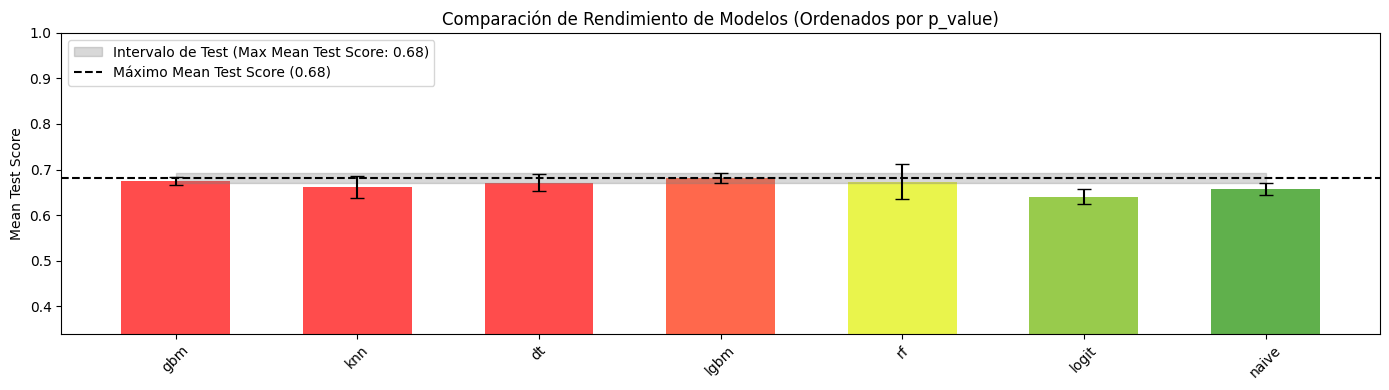

In [91]:
# Ordenar el DataFrame por el valor p creciente
results_df_sorted = results_df.sort_values(by='p_value')

# Crear el gráfico de barras
plt.figure(figsize=(14, 4))  # Ajustar el tamaño de la figura
bar_width = 0.6  # Hacer las barras el doble de anchas

# Obtener todos los modelos únicos después de ordenar
all_models = results_df_sorted['model'].unique()  # Obtener los modelos únicos

# Inicializar posición base
x_pos = np.arange(len(all_models))

# Crear un colormap personalizado para los valores p (ajustado a tus indicaciones)
colors = LinearSegmentedColormap.from_list(
    "p_value_gradient", [(0, 'red'), (0.075, 'yellow'), (1, 'green')])

# Normalizar los valores p de acuerdo con el rango entre 0 y 1
norm = Normalize(vmin=0, vmax=1)

# Graficar las métricas de test (mean_test_score y std_test_score)
max_mean_test_score = -np.inf  # Para encontrar el mayor mean_test_score
interval_lower_test_max = None  # Para almacenar el valor del intervalo inferior
interval_upper_test_max = None  # Para almacenar el valor del intervalo superior
min_mean_test_score = np.inf  # Para encontrar el menor mean_test_score

for i, model in enumerate(all_models):
    # Filtrar los datos para cada modelo
    filtered_df = results_df_sorted[results_df_sorted['model'] == model]
    
    # Obtener las métricas del modelo
    mean_test_score = filtered_df['mean_test_score'].values[0]
    test_std = filtered_df['std_test_score'].values[0] * 3  # Multiplicar la desviación estándar por 3
    p_value = filtered_df['p_value'].values[0]
    
    # Obtener los límites del intervalo de test
    interval_lower_test = filtered_df['interval_lower_test'].values[0]
    interval_upper_test = filtered_df['interval_upper_test'].values[0]
    
    # Actualizar el máximo y el mínimo mean_test_score, así como los límites del intervalo
    if mean_test_score > max_mean_test_score:
        max_mean_test_score = mean_test_score
        interval_lower_test_max = interval_lower_test
        interval_upper_test_max = interval_upper_test
    if mean_test_score < min_mean_test_score:
        min_mean_test_score = mean_test_score

    # Asignar el color basado en el valor p usando el colormap
    color = colors(norm(p_value))  # Aplicar normalización y obtener el color

    # Posicionar las barras
    plt.bar(x_pos[i], mean_test_score, yerr=test_std, capsize=5, 
            color=color, width=bar_width, alpha=0.7)

# Añadir una banda translucida entre interval_lower_test_max y interval_upper_test_max
plt.fill_between(
    [0, len(all_models) - 1],  # Todo el ancho del gráfico
    interval_lower_test_max, interval_upper_test_max,
    color='gray', alpha=0.3, label=f'Intervalo de Test (Max Mean Test Score: {max_mean_test_score:.2f})'
)

# Añadir línea horizontal en el valor máximo de mean_test_score
plt.axhline(y=max_mean_test_score, color='black', linestyle='--', label=f'Máximo Mean Test Score ({max_mean_test_score:.2f})')

# Añadir etiquetas y título
plt.title('Comparación de Rendimiento de Modelos (Ordenados por p_value)')
plt.xticks(x_pos, all_models, rotation=45)
plt.ylabel('Mean Test Score')

# Ajustar el límite del eje y
plt.ylim(min_mean_test_score - 0.3, 1.0)  # Se ajusta el límite inferior para incluir el valor mínimo

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

[LightGBM] [Info] Number of positive: 17759, number of negative: 17759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 35518, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.6452678248280854
Precision: 0.3205940161607338
Recall: 0.6445664105378704
F1 Score: 0.4282068110552031
ROC AUC Score: 0.6450081468610488


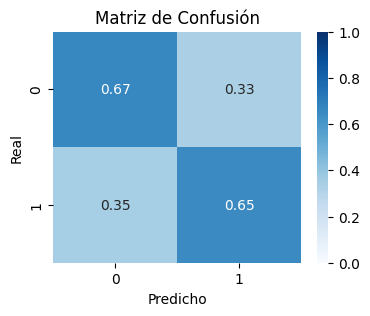

              precision    recall  f1-score   support

           0       0.66      0.67      0.66     17759
           1       0.66      0.65      0.66     17759

    accuracy                           0.66     35518
   macro avg       0.66      0.66      0.66     35518
weighted avg       0.66      0.66      0.66     35518



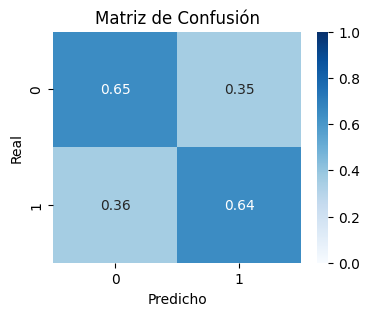

              precision    recall  f1-score   support

           0       0.87      0.65      0.74     17549
           1       0.32      0.64      0.43      4555

    accuracy                           0.65     22104
   macro avg       0.60      0.65      0.59     22104
weighted avg       0.76      0.65      0.68     22104



In [92]:
lgbm_best_params = trials_df1[trials_df1['model'] == 'lgbm']['params']
lgbm_best_params

# Initialize the LightGBM model
lgbm_classifier = lgb.LGBMClassifier(random_state=42)
lgbm_classifier.fit(X_random, y_random)
y_pred = lgbm_classifier.predict(X = X_random)
y_pred_test = lgbm_classifier.predict(X_test)
y_pred_proba = lgbm_classifier.predict_proba(X_test)[:, 1]
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
resultados(y_random, y_pred)
resultados(y_test, y_pred_test)

Accuracy: 0.6473941368078175
Precision: 0.3149777219239118
Recall: 0.6052689352360044
F1 Score: 0.4143372407574391
ROC AUC Score: 0.6317985225499071


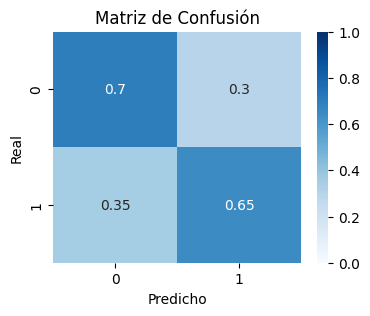

              precision    recall  f1-score   support

           0       0.66      0.70      0.68     17759
           1       0.68      0.65      0.66     17759

    accuracy                           0.67     35518
   macro avg       0.67      0.67      0.67     35518
weighted avg       0.67      0.67      0.67     35518



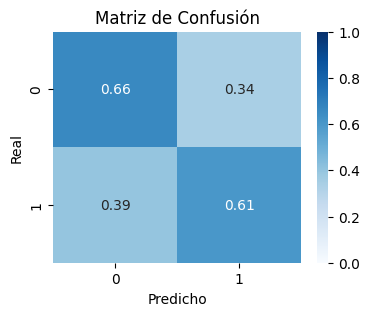

              precision    recall  f1-score   support

           0       0.87      0.66      0.75     17549
           1       0.31      0.61      0.41      4555

    accuracy                           0.65     22104
   macro avg       0.59      0.63      0.58     22104
weighted avg       0.75      0.65      0.68     22104



In [93]:
rf_best_params = trials_df1[trials_df1['model'] == 'rf']['params']
rf_best_params

# Initialize the RandomForest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_random, y_random)
y_pred = rf_classifier.predict(X = X_random)
y_pred_test = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
resultados(y_random, y_pred)
resultados(y_test, y_pred_test)

In [96]:
# Nombre del archivo CSV relacionado con "comportamiento_mejores_parametros"
csv_filename = "best_params_results.csv"

# Verifica si el archivo ya existe
if os.path.exists(csv_filename):
    # Si el archivo existe, solo se lee y se omite el proceso de evaluación y guardado
    results_df = pd.read_csv(csv_filename)
    print("El archivo ya existe. Se han cargado los resultados desde el archivo.")
else:
    # Si el archivo no existe, se realiza el cálculo y se guarda el archivo
    results_df = pd.DataFrame(columns=["model", "mean_train_score", "std_train_score", "interval_lower_train", 
                                       "interval_upper_train", "mean_test_score", "std_test_score", 
                                       "interval_lower_test", "interval_upper_test", "overfitting_risk", "p_value"])

    # Para cada modelo en trials_df1, crea y entrena el modelo utilizando los parámetros
    for index, row in trials_df1.iterrows():
        model_name = row['model']
        params = row['params']

        # Si el modelo es 'lgbm', no necesita prefijo como los otros modelos
        if model_name != 'lgbm':
            # Remover el prefijo (modelo_name + "_") de los parámetros
            params = {k.replace(f'{model_name}_', ''): v for k, v in params.items()}

        # Crear el modelo usando los parámetros
        model_class = model_dict[model_name]
        model = model_class(**params)

        # Dividir el dataset en entrenamiento y validación
        X_nm1, X_valid, y_nm1, y_valid = train_test_split(X_nm1, y_nm1, test_size=0.2, random_state=42)

        # Evaluar el modelo usando la función 'model_evaluation'
        df, overfitting_risk = model_evaluation(model, X_nm1, y_nm1, metric = chosen_metric)

        # Extraer los resultados de la evaluación
        mean_train_score = df.loc['train_set', 'mean']
        std_train_score = df.loc['train_set', 'std']
        interval_lower_train = df.loc['train_set', 'interval_lower']
        interval_upper_train = df.loc['train_set', 'interval_upper']
        
        mean_test_score = df.loc['test_set', 'mean']
        std_test_score = df.loc['test_set', 'std']
        interval_lower_test = df.loc['test_set', 'interval_lower']
        interval_upper_test = df.loc['test_set', 'interval_upper']

        # Extraer el valor p
        p_value = overfitting_risk.get('p_value', 1.0)

        # Crear un diccionario con los resultados para agregar al DataFrame
        results = {
            "model": model_name,
            "mean_train_score": mean_train_score,
            "std_train_score": std_train_score,
            "interval_lower_train": interval_lower_train,
            "interval_upper_train": interval_upper_train,
            "mean_test_score": mean_test_score,
            "std_test_score": std_test_score,
            "interval_lower_test": interval_lower_test,
            "interval_upper_test": interval_upper_test,
            "overfitting_risk": overfitting_risk['overfitting_likelihood'],
            "p_value": p_value
        }

        # Agregar los resultados al DataFrame de resultados
        results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
    
    # Guardar los resultados en el archivo CSV
    results_df.to_csv(csv_filename, index=False)
    print("El archivo ha sido creado y los resultados han sido guardados.")

El archivo ya existe. Se han cargado los resultados desde el archivo.


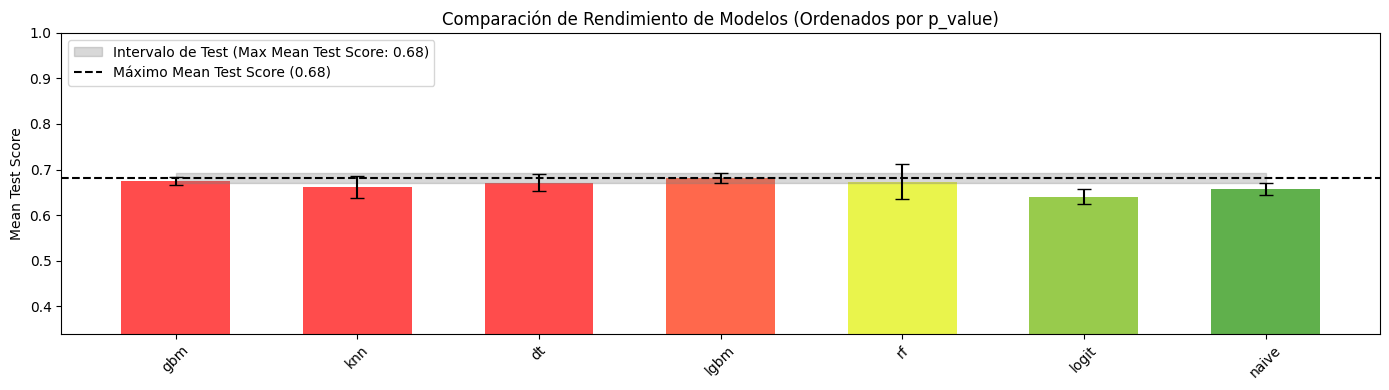

In [97]:
# Ordenar el DataFrame por el valor p creciente
results_df_sorted = results_df.sort_values(by='p_value')

# Crear el gráfico de barras
plt.figure(figsize=(14, 4))  # Ajustar el tamaño de la figura
bar_width = 0.6  # Hacer las barras el doble de anchas

# Obtener todos los modelos únicos después de ordenar
all_models = results_df_sorted['model'].unique()  # Obtener los modelos únicos

# Inicializar posición base
x_pos = np.arange(len(all_models))

# Crear un colormap personalizado para los valores p (ajustado a tus indicaciones)
colors = LinearSegmentedColormap.from_list(
    "p_value_gradient", [(0, 'red'), (0.075, 'yellow'), (1, 'green')])

# Normalizar los valores p de acuerdo con el rango entre 0 y 1
norm = Normalize(vmin=0, vmax=1)

# Graficar las métricas de test (mean_test_score y std_test_score)
max_mean_test_score = -np.inf  # Para encontrar el mayor mean_test_score
interval_lower_test_max = None  # Para almacenar el valor del intervalo inferior
interval_upper_test_max = None  # Para almacenar el valor del intervalo superior
min_mean_test_score = np.inf  # Para encontrar el menor mean_test_score

for i, model in enumerate(all_models):
    # Filtrar los datos para cada modelo
    filtered_df = results_df_sorted[results_df_sorted['model'] == model]
    
    # Obtener las métricas del modelo
    mean_test_score = filtered_df['mean_test_score'].values[0]
    test_std = filtered_df['std_test_score'].values[0] * 3  # Multiplicar la desviación estándar por 3
    p_value = filtered_df['p_value'].values[0]
    
    # Obtener los límites del intervalo de test
    interval_lower_test = filtered_df['interval_lower_test'].values[0]
    interval_upper_test = filtered_df['interval_upper_test'].values[0]
    
    # Actualizar el máximo y el mínimo mean_test_score, así como los límites del intervalo
    if mean_test_score > max_mean_test_score:
        max_mean_test_score = mean_test_score
        interval_lower_test_max = interval_lower_test
        interval_upper_test_max = interval_upper_test
    if mean_test_score < min_mean_test_score:
        min_mean_test_score = mean_test_score

    # Asignar el color basado en el valor p usando el colormap
    color = colors(norm(p_value))  # Aplicar normalización y obtener el color

    # Posicionar las barras
    plt.bar(x_pos[i], mean_test_score, yerr=test_std, capsize=5, 
            color=color, width=bar_width, alpha=0.7)

# Añadir una banda translucida entre interval_lower_test_max y interval_upper_test_max
plt.fill_between(
    [0, len(all_models) - 1],  # Todo el ancho del gráfico
    interval_lower_test_max, interval_upper_test_max,
    color='gray', alpha=0.3, label=f'Intervalo de Test (Max Mean Test Score: {max_mean_test_score:.2f})'
)

# Añadir línea horizontal en el valor máximo de mean_test_score
plt.axhline(y=max_mean_test_score, color='black', linestyle='--', label=f'Máximo Mean Test Score ({max_mean_test_score:.2f})')

# Añadir etiquetas y título
plt.title('Comparación de Rendimiento de Modelos (Ordenados por p_value)')
plt.xticks(x_pos, all_models, rotation=45)
plt.ylabel('Mean Test Score')

# Ajustar el límite del eje y
plt.ylim(min_mean_test_score - 0.3, 1.0)  # Se ajusta el límite inferior para incluir el valor mínimo

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

[LightGBM] [Info] Number of positive: 17759, number of negative: 17759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 35518, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.6292526239594644
Precision: 0.31116414193816144
Recall: 0.658397365532382
F1 Score: 0.42260269146762486
ROC AUC Score: 0.6400426054968309


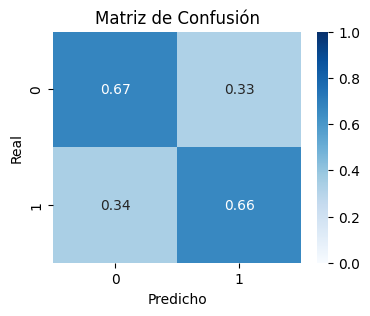

              precision    recall  f1-score   support

           0       0.67      0.67      0.67     17759
           1       0.67      0.66      0.67     17759

    accuracy                           0.67     35518
   macro avg       0.67      0.67      0.67     35518
weighted avg       0.67      0.67      0.67     35518



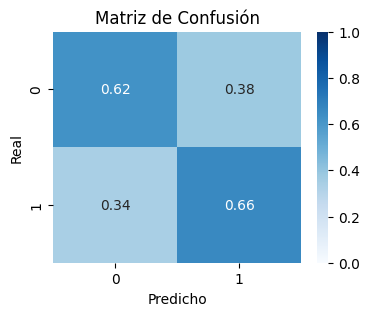

              precision    recall  f1-score   support

           0       0.88      0.62      0.73     17549
           1       0.31      0.66      0.42      4555

    accuracy                           0.63     22104
   macro avg       0.59      0.64      0.57     22104
weighted avg       0.76      0.63      0.66     22104



In [98]:
lgbm_best_params = trials_df1[trials_df1['model'] == 'lgbm']['params']
lgbm_best_params

# Initialize the LightGBM model
lgbm_classifier = lgb.LGBMClassifier(random_state=42)
lgbm_classifier.fit(X_nm1, y_nm1)
y_pred = lgbm_classifier.predict(X = X_nm1)
y_pred_test = lgbm_classifier.predict(X_test)
y_pred_proba = lgbm_classifier.predict_proba(X_test)[:, 1]
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test)
# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")
resultados(y_nm1, y_pred)
resultados(y_test, y_pred_test)

## Modelo final

#### Los siguientes parametros se obtuvieron con TPE de Optuna en una corrida en la cual no hay registro. Esto hace notar la aleatoriedad al buscar el mejor conjunto de parametros para determiando modelo, ya que Optuna pudo haber encontrado un maximo local en lugar del minimo global.
#### De cualquier manera, la precision en la mayoria de los modelos probados cayó dentro del intervalo de confianzapor obtenido del CV del conjunto prueba por lo tanto, no se puede rechazar la hipotesis que dichos modelos no sobreajustan